In [34]:
import pandas as pd
import numpy as np
import torch
import re
import string

import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
%matplotlib inline

from sentence_transformers import SentenceTransformer
import pandas as pd
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import TfidfVectorizer

import spacy
import nltk
from nltk.corpus import stopwords
import contractions

from config import OPENAI_API_KEY

In [35]:
df = pd.read_csv('cleaned_data.csv')

df.columns

Index(['month_of_action_date', 'career', 'score_reason', 'additional_comment',
       'cleaned_text'],
      dtype='object')

In [113]:
base_stopwords = set(ENGLISH_STOP_WORDS) 

custom_stopwords = {
    'material', 'materials', 'resources', 'resource', 'activity', 'twinkl'
}

stopword_set = base_stopwords.union(custom_stopwords)

In [114]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy
import re
import contractions

def topicModeling_preprocessing(df, source_column, target_column, spacy_model="en_core_web_lg"):

    stopword_pattern = r'\b(?:' + '|'.join(re.escape(word) for word in stopword_set) + r')\b'

    nlp = spacy.load(spacy_model)

    def clean_lemmatize_text(text):
        if not isinstance(text, str):
            return None
        
        text = contractions.fix(text)
        text = re.sub(r'\s+', ' ', text).strip()
        text = re.sub(stopword_pattern, '', text)

        doc = nlp(text)

        tokens = [token.text if token.text.lower() == "planner" else token.lemma_ for token in doc]
        
        clean_text = " ".join(tokens).strip()
        clean_text = re.sub(r'\s+', ' ', clean_text)

        return clean_text if clean_text else None

    df[target_column] = df[source_column].apply(clean_lemmatize_text)

    # Drop rows where cleaned text is empty or None
    df = df.dropna(subset=[target_column])

    return df

In [115]:
df = topicModeling_preprocessing(df, 'cleaned_text', 'preprocessed')

In [116]:
ux_content = df[~(df['score_reason'].isin(['Resource Quality', 'Variety of Materials']))]
len(ux_content)

264

In [117]:
docs = ux_content['cleaned_text'].dropna().tolist()

In [166]:
zeroshot_topic_list = [
    "Canceled",
    "Navigation and Search",
    "Renewal Price",
    "Wants Reminder or Notification",
    "Difficulty Downloading or Printing",
    "Can't Afford",
    "Refund",
    "Will Come Back",
    "Never Subscribed"
]

vectorizer_model = TfidfVectorizer(ngram_range=(1,4), stop_words=list(stopword_set))


topic_model = BERTopic(
    embedding_model="thenlper/gte-small", 
    min_topic_size=10,
    zeroshot_topic_list=zeroshot_topic_list,
    zeroshot_min_similarity=.85,
    representation_model=KeyBERTInspired(),
    vectorizer_model=vectorizer_model,
)
topics, _ = topic_model.fit_transform(docs)

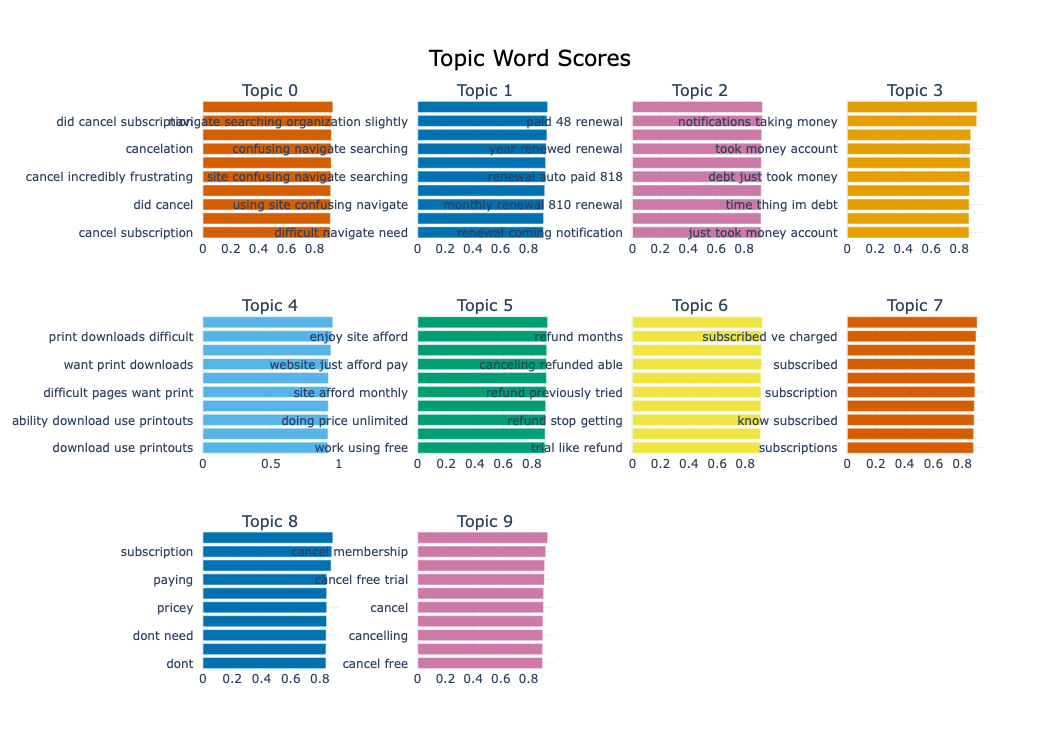

In [167]:
topic_model.visualize_barchart(top_n_topics=10, n_words=10)

In [168]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,25,-1_free trial_unlimited_cancel_forgot cancel,"[free trial, unlimited, cancel, forgot cancel,...",[the worst experience ever from any paid onlin...
1,0,27,Canceled,"[tried cancel, did cancel subscription, cancel...",[i never wanted the membership and then its so...
2,1,2,Navigation and Search,"[confusing navigate searching organization, na...",[very confusing to navigate too much at once w...
3,2,6,Renewal Price,"[charged monthly renewal 810, paid 48 renewal,...",[the first year i paid 48 and the renewal pric...
4,3,1,Wants Reminder or Notification,"[notifications taking money using, notificatio...",[you should give notifications for when taking...
5,4,5,Difficulty Downloading or Printing,"[want print downloads difficult, print downloa...",[not very easy to find product and just print ...
6,5,5,Can't Afford,"[website just afford, enjoy site afford, free ...",[i cannot afford this monthly fee at this mome...
7,6,24,Refund,"[request refund, refund months, refund, cancel...",[after receiving a receipt that states a refun...
8,7,24,Never Subscribed,"[paying subscription, subscribed ve charged, p...",[i never intended to subscribe in the first pl...
9,8,85,8_cancel_subscription_subscriptions_paying,"[cancel, subscription, subscriptions, paying, ...",[its really unfortunate how difficult it is to...
